In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import periodictable
from Bio.PDB import *
from periodictable import xsf
from math import pi

%matplotlib inline

In [10]:
# Some handy functions
def rotMatrix(theta):
    '''z-axis rotation matrix'''
    
    R = np.array([[np.cos(theta), np.sin(theta), 0],
    [-np.sin(theta),np.cos(theta),0],
    [0, 0, 1]])
    
    return R
    
def cartesian_to_spherical(vector):
    """Convert the Cartesian vector [x, y, z] to spherical coordinates [r, theta, phi].

    The parameter r is the radial distance, theta is the polar angle, and phi is the azimuth.


    @param vector:  The Cartesian vector [x, y, z].
    @type vector:   numpy rank-1, 3D array
    @return:        The spherical coordinate vector [r, theta, phi].
    @rtype:         numpy rank-1, 3D array
    """

    # The radial distance.
    r = np.linalg.norm(vector)

    # Unit vector.
    unit = vector / r

    # The polar angle.
    theta = math.acos(unit[2])

    # The azimuth.
    phi = math.atan2(unit[1], unit[0])

    # Return the spherical coordinate vector.
    return array([r, theta, phi], float64)

In [39]:
# Pattern simulation functions
def simulate_patterns(Npatterns, wavelength=.5, decim=1):
    
    parser = PDBParser(QUIET=True)

    structure=parser.get_structure("", "pdb/pyrene.pdb")

    gatoms = structure.get_atoms()
    atoms = []
    for at in gatoms:
        atoms.append(at)

    # generate the list of random uniforms rotations
    randomRot = 2*pi*np.random.rand(Npatterns)

    continuous_patterns=[]
    for j in range(Npatterns):
        theta = randomRot[j]
        
        R = rotMatrix(theta)
        #R = eye(3)
        
        I = projection_on_detector(atoms,wavelength,R, decim=decim)
        continuous_patterns.append(I)
        
        #plot_diffraction_patterns(I,noisy_I)
        #np.savetxt('/Users/Julien/Dropbox/MPhil_thesis/Codes/Patterns/data/'+str(j)+"_2BUK_cont.txt",I,fmt='%1.4e')
       
        print("Pattern number " + str(j) + " generated")

    return continuous_patterns

def projection_on_detector(atoms,wavelength,R, decim=1):

    
    ''' Note in this part theta in spherical coords is equat to theta in scattering'''
    
    
    qmax = 4*pi/wavelength # in Angstroms
    D = 1e-2*1e10 # in Angstroms
    #px = 3.38e-5*1e10 # in Angstroms
    px= 1e-4*1e10
    
    re = 2.8179403267*1e-15 # in m
    nphotons = 1e16
    beamarea = 1e-14 # in m**2
    
    X,Y = np.mgrid[-31:32:decim,-31:32:decim]
    X = px*X
    Y = px*Y
    
    N = len(X)
    
    Rp = np.sqrt(X**2+Y**2)
    theta = np.arctan(Rp/D)
    phi = np.arctan2(Y,X)
    
    x0 = 0
    y0 = 0
    z0 = -2*pi/wavelength
    r = 2*pi/wavelength
    x = x0+ r* np.sin(theta) * np.cos(phi)
    y = y0+ r* np.sin(theta) * np.sin(phi)
    z = z0+ r* np.cos(theta)
    #TF calculation

    F = np.zeros((N,N),dtype="complex")
    
    normq = np.sqrt(x**2 + y**2 + z**2)
    
    for at in atoms:
        el = periodictable.elements.symbol(at.element)
    
        pos = at.get_coord()
        
        pos = R.dot(pos) #rotation of the sample
        Xdata = xsf.Xray(el)
                    
        Qpos = x*pos[0] +y*pos[1]+z*pos[2]
        
        F += Xdata.f0(normq)*np.exp(1j*Qpos)
                
    I = abs(F)**2*re**2*nphotons/beamarea*(px/D)**2*np.cos(theta)

    return I

Pattern number 0 generated


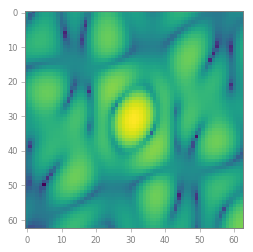

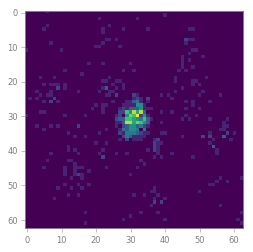

In [42]:
##### simulation 
patterns = simulate_patterns(1, decim=1)
for pat in patterns:
    plt.figure()
    plt.imshow(np.log(pat))
    plt.figure()
    plt.imshow(np.random.poisson(pat))

In [30]:
s=1000
np.random.poisson(s*pat).sum()

570

In [35]:
patterns

[array([[  5.09379219e-06,   6.49066190e-06,   7.45550956e-06, ...,
           1.78147975e-04,   2.30438580e-04,   2.75851366e-04],
        [  2.14003242e-06,   3.45902174e-06,   4.72152698e-06, ...,
           2.11456214e-04,   2.77062045e-04,   3.35689377e-04],
        [  1.08806379e-06,   1.99545383e-06,   3.03276537e-06, ...,
           2.19416787e-04,   2.93949710e-04,   3.62724338e-04],
        ..., 
        [  8.75174834e-06,   6.20005035e-06,   1.05221887e-05, ...,
           7.13282387e-07,   4.32816553e-07,   4.33733030e-07],
        [  1.92877826e-05,   9.78267886e-06,   8.25315315e-06, ...,
           4.75863261e-07,   2.74935677e-07,   2.82312415e-07],
        [  3.14724006e-05,   1.58471357e-05,   8.98935349e-06, ...,
           7.65302602e-07,   1.15555950e-06,   1.83274065e-06]]),
 array([[  2.02991110e-05,   1.46933750e-05,   1.04131105e-05, ...,
           8.54047771e-06,   1.26572257e-05,   1.56904654e-05],
        [  2.22145511e-05,   1.69602792e-05,   1.28595078e-0